# DeepFM

## 0. Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

In [2]:
# load data
def transaction_preprocess(transactions, train_bounds, test_bounds):
    transactions = transactions.copy() 
    transactions["prod"] = transactions["prod"].astype('category').cat.codes
    transactions["customer"] = transactions["customer"].astype('category').cat.codes
    transactions["state"] = transactions["state"].astype('category').cat.codes + 1
    transactions["ind_code"] = transactions["ind_code"].astype('category').cat.codes + 1
    transactions["ind_seg_code"] = transactions["ind_seg_code"].astype('category').cat.codes + 1
    transactions["label"] = 1
    transactions["prod_customer"] = list(zip(transactions["customer"], transactions["prod"]))
    transaction = transactions.dropna()
    
    train = transactions[(transaction.day >= train_bounds[0]) & (transactions.day < train_bounds[1])]
    test = transactions[(transaction.day >= test_bounds[0]) & (transactions.day < test_bounds[1])]
    
    customers = transactions["customer"].unique()
    products = transactions["prod"].unique()
    
    hit_combo = set(list(zip(transactions["day"], transactions["customer"], transactions["prod"])))
    
    test_days = test["day"].unique()
    hit_combo_2 = list(zip(test["day"], test["customer"]))
    
    prod_samp_size = 200
    prod_rnd_sample = np.array([np.random.choice(products, size=prod_samp_size * len(hit_combo_2))]).T
    test_rnd_sample = [(tday, tcustomer, prod_rnd_sample[i][0]) for i in range(prod_samp_size) for tday, tcustomer in hit_combo_2]
    
    
    not_faulty = [tuple(test_rnd_sample[row]) not in hit_combo for row in range(len(test_rnd_sample))]
    test_rnd_sample = np.array(test_rnd_sample)
    test_rnd_sample = test_rnd_sample[not_faulty]
    
    # Random sample
    test_rnd_sample = pd.DataFrame(test_rnd_sample,
                                   columns=["day", "customer", "prod"]).drop_duplicates()
    test_rnd_sample = test_rnd_sample.merge(transactions[["customer", "domestic", "state", "ind_code",
                                                            "ind_seg_code"]].drop_duplicates(),
                                              on="customer")
    test_rnd_sample["label"] = 0
    test_rnd_sample = test_rnd_sample.append(test[["day", "customer", "prod", "domestic", "state", "ind_code",
                                                            "ind_seg_code", "label"]], ignore_index=True)
    
    SAMPLE_SIZE = int(np.ceil(1.0 * len(train)))
    train_days = train["day"].unique()
    
    train_rnd_sample = np.array([np.random.choice(train_days, size=SAMPLE_SIZE),\
                                              np.random.choice(customers, size=SAMPLE_SIZE),\
                                              np.random.choice(products, size=SAMPLE_SIZE)]).T
    
    not_faulty = [tuple(train_rnd_sample[row,:]) not in hit_combo for row in range(train_rnd_sample.shape[0])]
    train_rnd_sample = train_rnd_sample[not_faulty]
    
    # Random sample
    train_rnd_sample = pd.DataFrame(train_rnd_sample,
                                   columns=["day", "customer", "prod"]).drop_duplicates()
    train_rnd_sample = train_rnd_sample.merge(transactions[["customer", "domestic", "state", "ind_code",
                                                            "ind_seg_code"]].drop_duplicates(),
                                              on="customer")
    train_rnd_sample["label"] = 0
    train_rnd_sample = train_rnd_sample.append(train[["day", "customer", "prod", "domestic", "state", "ind_code",
                                                            "ind_seg_code", "label"]], ignore_index=True)
    
    return transactions, train_rnd_sample.sample(frac=1).reset_index(drop=True), test_rnd_sample.sample(frac=1).reset_index(drop=True), products, customers

In [3]:
def test_day(transactions, day):
    transactions = transactions.copy() 
    transactions["prod"] = transactions["prod"].astype('category').cat.codes
    transactions["customer"] = transactions["customer"].astype('category').cat.codes
    transactions["state"] = transactions["state"].astype('category').cat.codes + 1
    transactions["ind_code"] = transactions["ind_code"].astype('category').cat.codes + 1
    transactions["ind_seg_code"] = transactions["ind_seg_code"].astype('category').cat.codes + 1
    transactions["label"] = 1
    transactions["prod_customer"] = list(zip(transactions["customer"], transactions["prod"]))
    transaction = transactions.dropna()
    
    test = transactions[transactions.day == day]
    
    customers = transactions["customer"].unique()
    products = transactions["prod"].unique()
    
    hit_combo = set(list(zip(transactions["day"], transactions["customer"], transactions["prod"])))
    
    test_days = test["day"].unique()
    hit_combo_2 = list(zip(test["day"], test["customer"]))
    
    prod_samp_size = 200
    prod_rnd_sample = np.array([np.random.choice(products, size=prod_samp_size * len(hit_combo_2))]).T
    test_rnd_sample = [(tday, tcustomer, products[i]) for i in range(len(products)) for tday, tcustomer in hit_combo_2]
    
    
    not_faulty = [tuple(test_rnd_sample[row]) in hit_combo for row in range(len(test_rnd_sample))]
    
    test_rnd_sample = pd.DataFrame(test_rnd_sample,
                                   columns=["day", "customer", "prod"]).drop_duplicates()
    test_rnd_sample = test_rnd_sample.merge(transactions[["customer", "domestic", "state", "ind_code",
                                                            "ind_seg_code"]].drop_duplicates(),
                                              on="customer")
    test_rnd_sample["label"] = not_faulty
    
    return test

In [6]:
transactions = pd.read_csv("dataset/transaction_history.csv")
transformed, train, test, products, customers = transaction_preprocess(transactions, (0, 1000), (1000, 1250))

C:\Users\david\AppData\Local\Temp\ipykernel_9856\3161337532.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_rnd_sample = test_rnd_sample.append(test[["day", "customer", "prod", "domestic", "state", "ind_code",
C:\Users\david\AppData\Local\Temp\ipykernel_9856\3161337532.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_rnd_sample = train_rnd_sample.append(train[["day", "customer", "prod", "domestic", "state", "ind_code",


## 1. Models

In [7]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers(df):
    day_input = Input((1,), name = 'day')
    num_inputs = [day_input]
    cat_input = [Input((1,), name= col) for col in ['customer', 'prod', 'state', 'ind_code',
       'ind_seg_code', 'domestic']]
    cat_sl_inputs = [cat_input]

    inputs = num_inputs + cat_sl_inputs
    
    return inputs

inputs = define_input_layers(transformed)

In [8]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='fm_1d_output/add_5:0', description="created by layer 'fm_1d_output'")


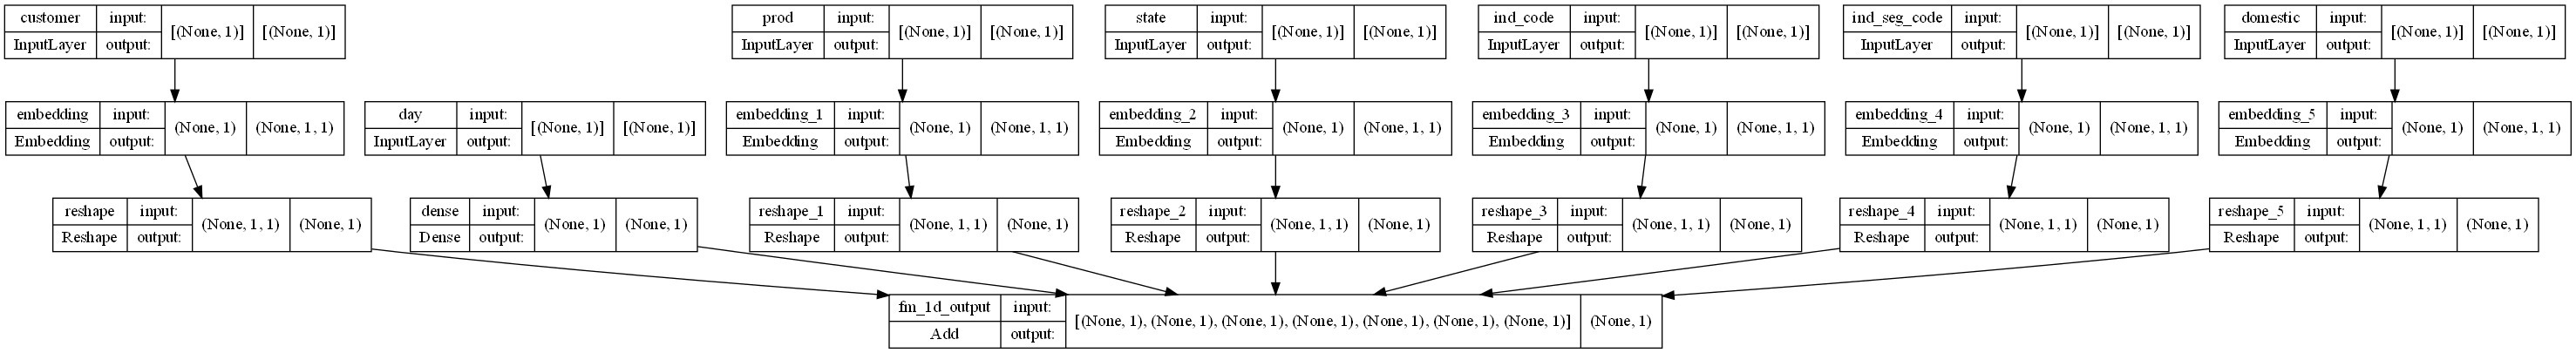

In [9]:
def fm_1d(inputs):
    num_inputs, cat_inputs = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d  = [Dense(1)(num_inputs)]
    
    cat_sl_embed_1d = [Embedding(transformed[inpt.name].nunique() + 1, 1)(inpt) for inpt in cat_inputs]
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d)
    print(y_fm_1d)
    return y_fm_1d

y_1d = fm_1d(inputs)
fm_model_1d = Model(inputs, y_1d)
plot_model(fm_model_1d, show_shapes=True, show_layer_names=True)

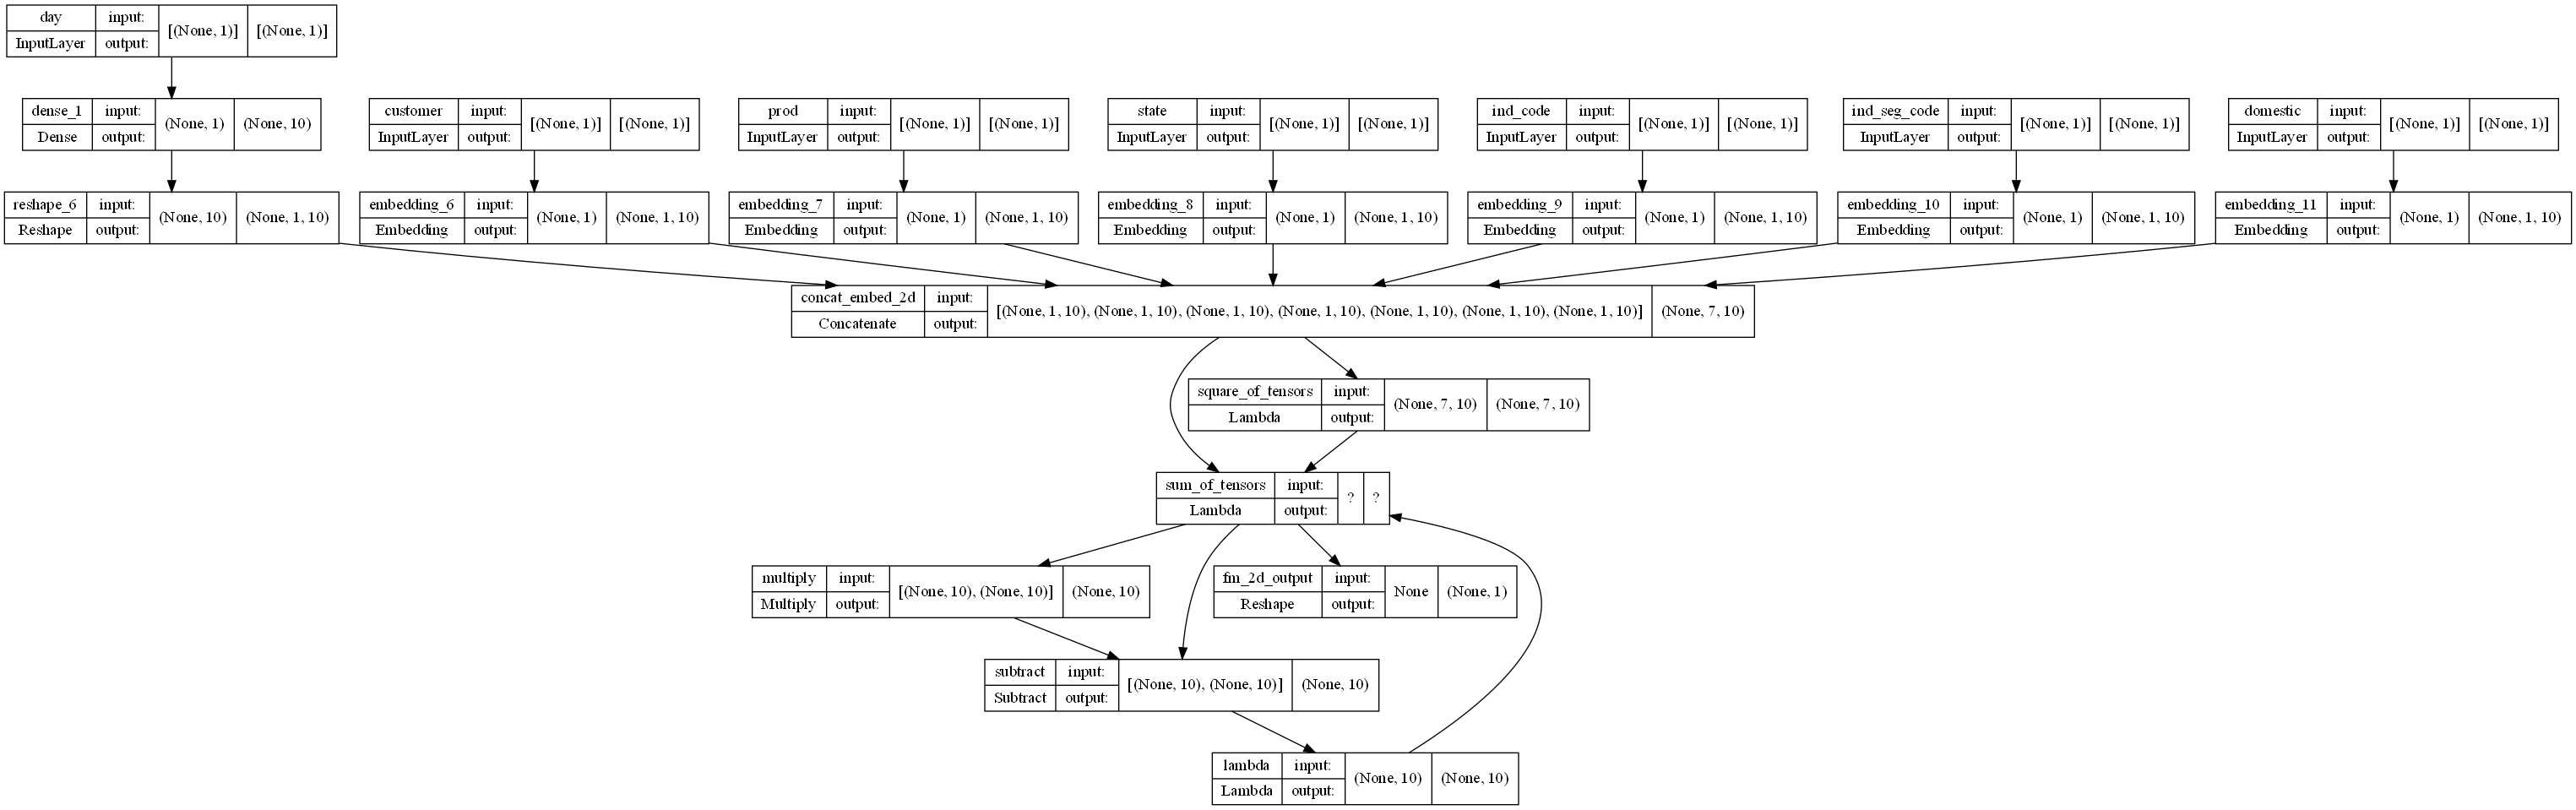

In [10]:
def fm_2d(inputs, k):
    num_inputs, cat_inputs = inputs
    
    num_dense_2d = [Dense(k)(num_inputs)]
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d]
    
    cat_sl_embed_2d = [Embedding(transformed[inpt.name].nunique() + 1, k)(inpt) for inpt in cat_inputs]
    
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d)
    
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d
    
y_2d, embed_2d = fm_2d(inputs, 10)
fm_model_2d = Model(inputs, y_2d)
plot_model(fm_model_2d, show_shapes=True, show_layer_names=True)

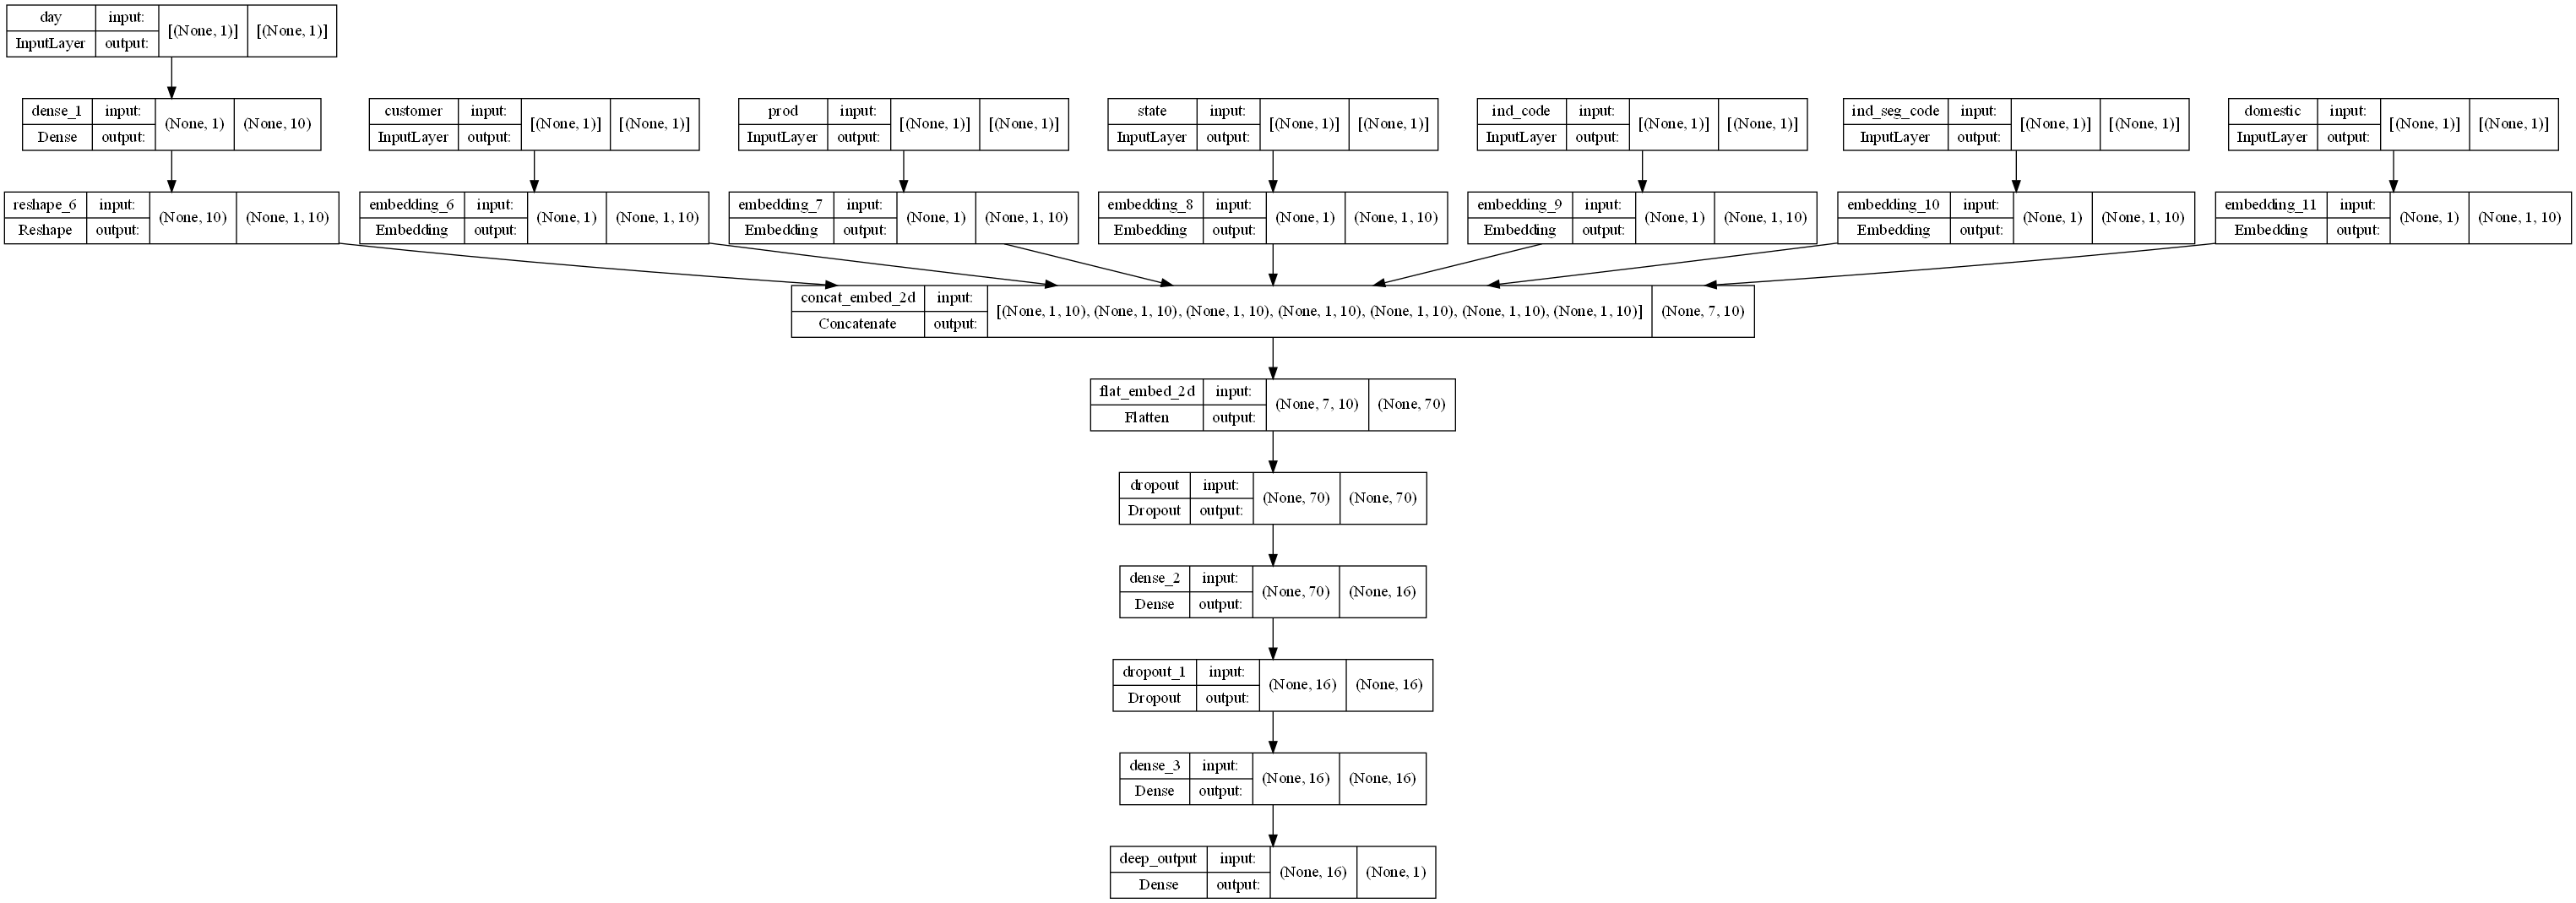

In [11]:
def dnn_part(embed_2d, dnn_dim, dnn_dr):
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = dnn_part(embed_2d, [16, 16], 0.5)
fm_model_dnn = Model(inputs, y_dnn)
plot_model(fm_model_dnn, show_shapes=True, show_layer_names=True)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='fm_1d_output/add_5:0', description="created by layer 'fm_1d_output'")


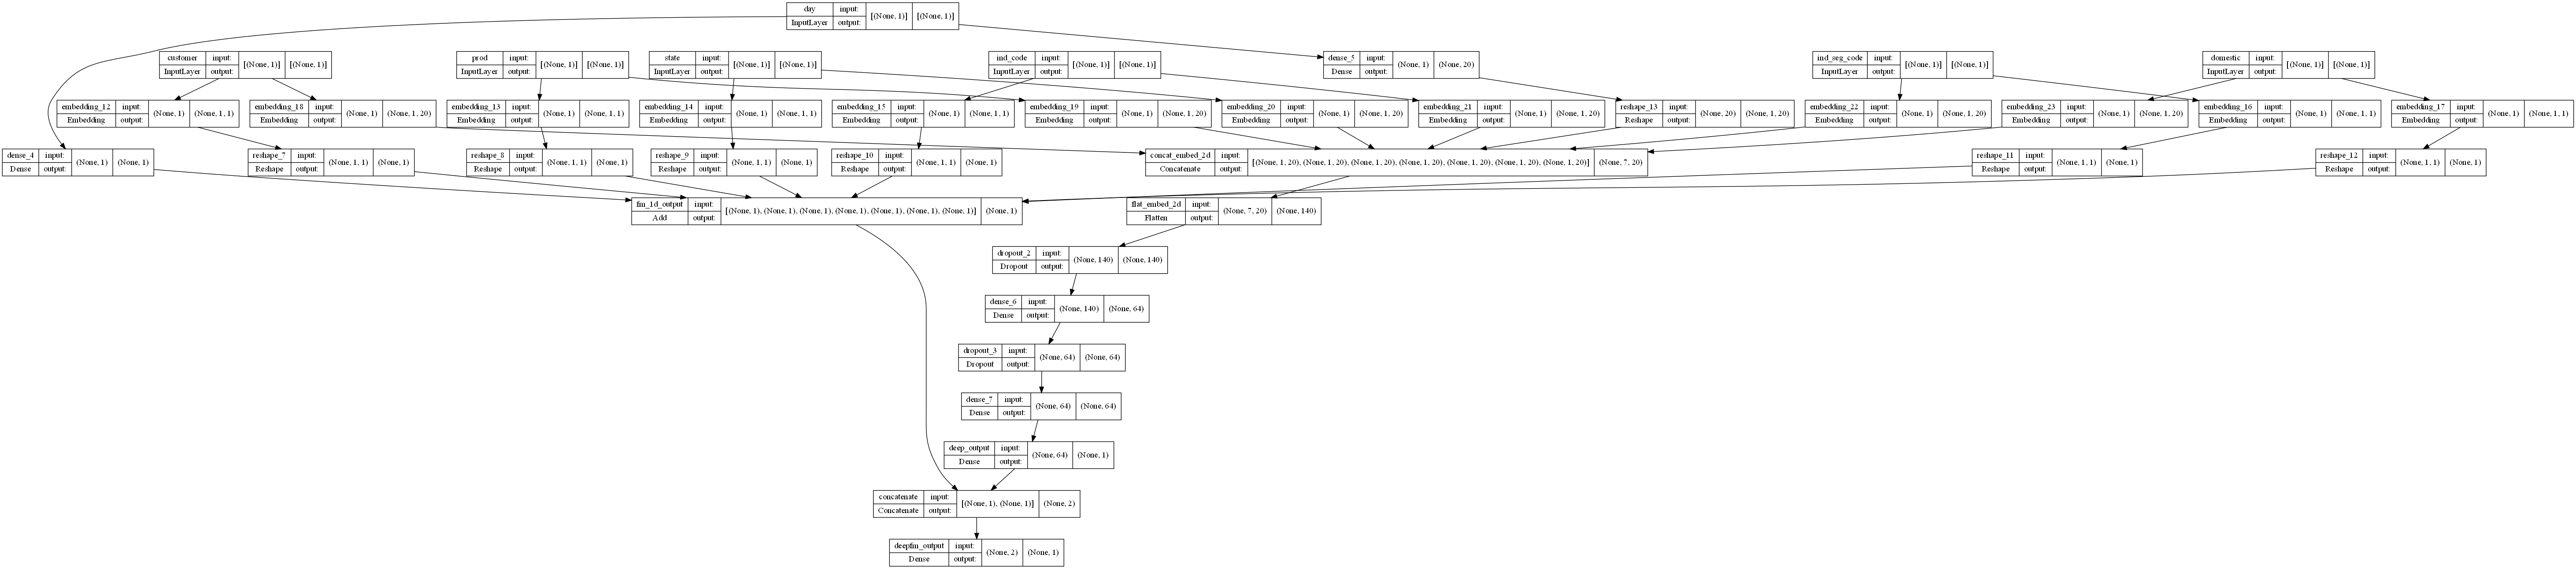

In [12]:
params = {
    'k':20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}

def deep_fm_model(k, dnn_dim, dnn_dr):
    
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    y_dnn = dnn_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_dnn])
    y = Dense(1, name = 'deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return deep_fm_model
deepfm_model = deep_fm_model(**params)
plot_model(deepfm_model, show_shapes=True, show_layer_names=True)

## 2. Evaluation

In [13]:
def df2xy(df, model):
    x = [df[inp.name].values for inp in model.inputs]
    y = df.label.values
    return x,np.asarray(y).astype('float32')

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

y_1d = fm_1d(inputs)
fm_model_1d = Model(inputs, y_1d)
train_x, train_y = df2xy(train, fm_model_1d)
fm_model_1d.compile(loss = 'MSE', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_ckp = ModelCheckpoint(filepath='./models/1d.h5', 
                                monitor='val_loss',
                                save_weights_only=True, 
                                save_best_only=True)
callbacks = [early_stop, model_ckp]
train_history = fm_model_1d.fit(train_x, train_y, 
                                      epochs=100, batch_size=2048, 
                                      validation_split=0.1, 
                                      callbacks = callbacks)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='fm_1d_output/add_5:0', description="created by layer 'fm_1d_output'")
Epoch 1/100
403/403 [==============================] - 21s 42ms/step - loss: 5212.0039 - val_loss: 102.8930
Epoch 2/100
403/403 [==============================] - 14s 36ms/step - loss: 13.7364 - val_loss: 1.3168
Epoch 3/100
403/403 [==============================] - 17s 41ms/step - loss: 1.2868 - val_loss: 1.2586
Epoch 4/100
403/403 [==============================] - 17s 42ms/step - loss: 1.2246 - val_loss: 1.1896
Epoch 5/100
403/403 [==============================] - 18s 45ms/step - loss: 1.1488 - val_loss: 1.1072
Epoch 6/100
403/403 [==============================] - 18s 44ms/step - loss: 1.0601 - val_loss: 1.0125
Epoch 7/100
403/403 [==============================] - 18s 45ms/step - loss: 0.9600 - val_loss: 0.9073
Epoch 8/100
403/403 [==============================] - 17s 41ms/step - loss: 0.8506 - val_loss: 0.7944
Epoch 9/100
40

In [ ]:
y_2d, embed_2d = fm_2d(inputs, 10)
fm_model_2d = Model(inputs, y_2d)
train_x, train_y = df2xy(train, fm_model_2d)
fm_model_2d.compile(loss = 'MSE', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_ckp = ModelCheckpoint(filepath='./model/2d.h5', 
                                monitor='val_loss',
                                save_weights_only=True, 
                                save_best_only=True)
callbacks = [early_stop]
train_history = fm_model_2d.fit(train_x, train_y,
                                      epochs=100, batch_size=2048, 
                                      validation_split=0.1, 
                                      callbacks = callbacks)

In [ ]:
deepfm_model = deep_fm_model(**params)
train_x, train_y = df2xy(train, deepfm_model)
deepfm_model.compile(loss = 'MSE', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_ckp = ModelCheckpoint(filepath='./model/deepfm.h5', 
                                monitor='val_loss',
                                save_weights_only=True, 
                                save_best_only=True)
callbacks = [early_stop]
train_history = deepfm_model.fit(train_x, train_y, 
                                      epochs=100, batch_size=2048, 
                                      validation_split=0.1, 
                                      callbacks = callbacks)

In [ ]:
test_x, test_y = df2xy(test, fm_model_2d)
eval_2d = test.copy()
eval_2d["score"] = fm_model_2d.predict(test_x,
                            batch_size=2048).flatten()
eval_2d = eval_2d.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(5)
test_x, test_y = df2xy(test, fm_model_1d)
eval_1d = test.copy()
eval_1d["score"] = fm_model_1d.predict(test_x,
                            batch_size=2048).flatten()
eval_1d = eval_1d.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(5)
test_x, test_y = df2xy(test, deepfm_model)
eval_deepfm = test.copy()
eval_deepfm["score"] = deepfm_model.predict(test_x,
                            batch_size=2048).flatten()
eval_deepfm = eval_deepfm.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(5)

In [ ]:
ana = eval_1d[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
print(f"Hit score 1d: {ana.label.mean()}")
ana = eval_2d[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
print(f"Hit score 2d: {ana.label.mean()}")
ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
print(f"Hit score deepfm: {ana.label.mean()}")

## 3. Feature importance

In [36]:
import lime
from lime import lime_tabular

In [ ]:
transformed.columns

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_x),
    mode='regression'
)

In [ ]:
exp = explainer.explain_instance(
    data_row=np.array(test_x).T, 
    predict_fn=fm_model_1d
)

In [ ]:
test_x[0]